<div align="center">
    <h1 style="background-color:#F9EBEA; padding:10px;">Finding remarkably dense sequences of contacts in link streams for COVID-19</h1>
</div>

## Projet tuteuré : Master 1 Réseaux et Systèmes Autonomes (RSA)

### Etape 1: Création d’une projection du flux de liens dans un graphe où chaque lien est associé à un nœud. Deux nœuds du graphe sont reliés si deux flux de liens se chevauchent à la fois structurellement mais aussi temporellement.  

#### Idriss KOURBANHOUSSEN – Ounas YHIA – Thinujan THILAHENDRAN

In [1]:
import csv
import pandas as pd
import networkx as nx

# Création d'un dictionnaire pour stocker les données liées au flux de liens de notre dataset
# Le dictionnaire est structuré ainsi : {(t_début, i, j) : t_fin}
def create_dictionnaire (nom_fichier):
    # Création d'un dictionnaire vide 
    dictionnaire_temps_max = {}

    # Lecture du fichier CSV
    with open(nom_fichier, 'r') as fichier_csv:
        lecteur_csv = csv.reader(fichier_csv, delimiter='\t')

        # Parcours de chaque ligne du fichier
        for ligne in lecteur_csv:
            # Extraction des valeurs de la ligne
            t, i, j = map(int, ligne[:3])

            # Génération d'une clé unique pour la paire d'IDs (t, i, j)
            cle = (t, i, j)

            # On verifie si la clé existe déjà dans le dictionnaire
            if (t-20, i, j) in dictionnaire_temps_max:
                # Si la clé n'existe pas, on ajoute une nouvelle entrée au dictionnaire
                # t-20 --> car chaque contact dure 20s
                dictionnaire_temps_max[(t-20, i, j)] = t
            else:
                dictionnaire_temps_max[cle] = t
        return dictionnaire_temps_max

# Affichage du dictionnaire résultant
dictionnaire_temps_max = create_dictionnaire("primaryschool.csv")
print("Dictionnaire : ", dictionnaire_temps_max)

##########################################################################################################################

# Lecture du fichier CSV dans un DataFrame pandas
df = pd.read_csv("primaryschool.csv", header=None, names=["t", "i", "j", "Ci", "Cj"], sep='\t')

# Création d'un graphe non dirigé
G = nx.Graph()

# Ajout des nœuds au graphe à partir du dictionnaire créé précedemment   
for cle, _ in dictionnaire_temps_max.items():
    G.add_node(cle)

# Ajout des liens au graphe à partir du dictionnaire créé précedemment   
while(dictionnaire_temps_max != {}):
    # 1er élément du dictionnaire
    t1_debut, i1, j1 = next(iter(dictionnaire_temps_max)) 
    t1_fin = dictionnaire_temps_max[(t1_debut, i1, j1)]
    # On supprime le 1er élément du dictionnaire car on va maintenant le comparer avec tout les autres noeuds
    del dictionnaire_temps_max[(t1_debut, i1, j1)] 
    
    # On vérifie le chevauchement entre le premier élément du dictionnaire avec tout les autres éléments du dictionnaire
    for cle2, valeur2 in dictionnaire_temps_max.items():  
        t2_debut, i2, j2 = cle2
        t2_fin = valeur2
        if (i1 == i2) | (i1 == j2) | (j1 == i2) | (j1 == j2): # les deux éléments ont-ils un nœud en communs ?
            if (t1_debut >= t2_debut) & (t1_debut <= t2_fin): # leurs intervalles de temps se chevauchent-ils ?
                G.add_edge((t1_debut,i1,j1),(t2_debut,i2,j2))
    

# Affichage du nombre de nœuds et de liens dans le graphe
print("Nombre de nœuds :", len(G.nodes))
print("Nombre de liens :", len(G.edges))


Dictionnaire :  {(31220, 1558, 1567): 31240, (31220, 1560, 1570): 31220, (31220, 1567, 1574): 31240, (31220, 1632, 1818): 31240, (31220, 1632, 1866): 31240, (31220, 1673, 1698): 31240, (31220, 1819, 1836): 31240, (31220, 1819, 1866): 31220, (31240, 1741, 1820): 31260, (31240, 1809, 1822): 31240, (31260, 1558, 1564): 31280, (31260, 1558, 1567): 31280, (31260, 1560, 1570): 31260, (31260, 1564, 1567): 31280, (31260, 1564, 1574): 31280, (31260, 1567, 1574): 31280, (31260, 1632, 1866): 31280, (31260, 1673, 1698): 31280, (31260, 1768, 1783): 31260, (31260, 1802, 1805): 31280, (31260, 1802, 1831): 31260, (31280, 1503, 1545): 31280, (31280, 1632, 1818): 31280, (31280, 1632, 1819): 31280, (31280, 1757, 1760): 31280, (31300, 1459, 1516): 31300, (31300, 1558, 1567): 31300, (31300, 1567, 1574): 31300, (31300, 1617, 1641): 31320, (31300, 1632, 1866): 31300, (31300, 1673, 1698): 31320, (31300, 1757, 1761): 31300, (31300, 1809, 1822): 31300, (31320, 1452, 1498): 31340, (31320, 1452, 1520): 31320, (31

Nombre de nœuds : 93581
Nombre de liens : 59211


### Etape 2: Application d’un algorithme de détection de communauté sur ce graphe (dans notre cas, la méthode de Louvain), afin d’obtenir une partition des liens. 

In [2]:
import networkx as nx
from community import community_louvain

# On applique l'algorithme de Louvain sur notre Graphe 
partition = community_louvain.best_partition(G)

# Affichage de la partition des liens
print("Partition : ", partition)

# Trouver le nombre de communautés
nombre_communautes = max(partition.values()) + 1

# Afficher le nombre de communautés
print("Nombre de communautés trouvées grace à la méthode de Louvain:", nombre_communautes)

# On crée ici un dictionnaire qui réorganise le dictionnaire de partition que nous avons dans l'étape 2
# Le nouveau dictionnaire 'group_links' est structuré ainsi : { id_group : [liste des noeuds]}
# On aura besoin pour l'étape 3
group_links = {}
for node_id, group_id in partition.items():
    if group_id not in group_links:
        group_links[group_id] = []
    group_links[group_id].append(node_id)


Partition :  {(31220, 1558, 1567): 0, (31220, 1560, 1570): 1, (31220, 1567, 1574): 0, (31220, 1632, 1818): 2, (31220, 1632, 1866): 2, (31220, 1673, 1698): 3, (31220, 1819, 1836): 2, (31220, 1819, 1866): 2, (31240, 1741, 1820): 4, (31240, 1809, 1822): 5, (31260, 1558, 1564): 6, (31260, 1558, 1567): 6, (31260, 1560, 1570): 7, (31260, 1564, 1567): 6, (31260, 1564, 1574): 6, (31260, 1567, 1574): 6, (31260, 1632, 1866): 8, (31260, 1673, 1698): 9, (31260, 1768, 1783): 10, (31260, 1802, 1805): 11, (31260, 1802, 1831): 11, (31280, 1503, 1545): 12, (31280, 1632, 1818): 13, (31280, 1632, 1819): 13, (31280, 1757, 1760): 14, (31300, 1459, 1516): 15, (31300, 1558, 1567): 16, (31300, 1567, 1574): 16, (31300, 1617, 1641): 17, (31300, 1632, 1866): 18, (31300, 1673, 1698): 19, (31300, 1757, 1761): 20, (31300, 1809, 1822): 21, (31320, 1452, 1498): 22, (31320, 1452, 1520): 22, (31320, 1468, 1520): 22, (31320, 1498, 1520): 22, (31320, 1502, 1522): 23, (31320, 1503, 1539): 24, (31320, 1643, 1648): 25, (313

In [3]:
import networkx as nx
import community

# Calcul de la modularité
modularity = community.modularity(partition, G)

print("Modularité :", modularity)

# La modularité est une mesure qui évalue la qualité d'une partition d'un graphe en communautés. 
# Elle permet de quantifier à quel point les nœuds d'une même communauté sont densément connectés entre eux, 
# tout en étant peu connectés avec les nœuds des autres communautés.

Modularité : 0.9998673295420131


### Etape 3: À partir de cette partition, nous avons calculé la densité de chaque communauté et n’avons retenu que les groupes pertinents, c'est-à-dire ceux qui sont plus denses que leur voisinage et qui sont suffisamment grands. Nous considérons que les groupes très petits ont un intérêt limité en termes de description du flux de liens.

In [4]:
###############################################################################################################

# On recrée le dictionnaire que nous avions créé dans la première étape car on l'avait supprimé au début du code
dictionnaire_temps_max = create_dictionnaire("primaryschool.csv")

###############################################################################################################

# Rappel : Le dictionnaire est structuré ainsi : {(t_début, i, j) : t_fin}
# On calcule ici l'intervalle de temps pendant laquelle les 2 noeuds passés en paramètre sont en chevauchement
def calculate_duration(node_a, node_b):
    t_debut, _, _ = node_a
    t_fin = dictionnaire_temps_max[node_b]
    # On vérifie le noeud 'b' ne commence pas avant le noeud 'a', pour éviter d'avoir une valeur négative
    if t_debut > t_fin:
        temp = t_debut
        t_debut = t_fin
        t_fin = temp
    return t_fin - t_debut

###############################################################################################################

# On calcule ici la densité de chaque communauté du graphe que nous avons détecté précédemment grace à la méthode de Louvain 
def calculate_density(link_partition, link_graph):
    # Création d'un dictionnaire vide pour stocker les densités calculées
    densities = {}

    for group_id, nodes in group_links.items():
        density = 0.0
        link_count = len(nodes)
        
        # On ne calcule la densité que des groupes qui possède plus de 1 noeud
        if link_count > 1:
            # Parcours de toutes les paires de noeuds dans le groupe
            for i in range(link_count - 1):
                for j in range(i + 1, link_count):
                    node_a = nodes[i]
                    node_b = nodes[j]

                    duration_sum = 0.0
                    overlap_count = 0

                    # Parcours de tous les liens entre les deux noeuds
                    for link_node_a in link_graph[node_a]:
                        for link_node_b in link_graph[node_b]:
                            if link_node_a == link_node_b: # Vérifie s'il y a un lien entre les deux noeuds
                                # Calcul de la durée du lien et ajout à la somme
                                duration = calculate_duration(link_node_a, link_node_b)
                                duration_sum += duration
                                overlap_count += 1

                    if overlap_count > 0:
                        # Calcul de la densité pour cette paire de noeuds
                        density += duration_sum / overlap_count

            # Normalisation de la densité par le nombre de paires de noeuds
            density /= link_count * (link_count - 1)

        # Stockage de la densité calculée pour ce groupe dans le dictionnaire
        densities[group_id] = density

    # Retourne le dictionnaire contenant les densités calculées pour chaque groupe
    return densities


densities = calculate_density(group_links, G)

print("Densités de chaque groupes : ", densities)

Densités de chaque groupes :  {0: 0.0, 1: 0.0, 2: 1.6666666666666667, 3: 0.0, 4: 0.0, 5: 0.0, 6: 10.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 1.6666666666666667, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 4.666666666666667, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 3.3333333333333335, 38: 0.0, 39: 2.051282051282051, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.8333333333333334, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 5.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 4.166666666666667, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 1.6666666666666667, 70: 0.0, 71: 4.166666666666667, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 3.3333333333333335, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 

In [5]:
# On normalise ici les densités calculées précédemment pour que les valeurs soient comprises entre 0 et 1
def normalize_density(densities):
    # Recherche de la densité maximale et minimale dans le dictionnaire de densités
    max_density = max(densities.values())
    min_density = min(densities.values())

    normalized_densities = {}
    for group_id, density in densities.items():
        # Calcul de la densité normalisée en utilisant la formule (valeur - min) / (max - min)
        normalized_density = (density - min_density) / (max_density - min_density)
        normalized_densities[group_id] = normalized_density

    # Retourne le dictionnaire de densités normalisées
    return normalized_densities

normal_density = normalize_density(densities)
print("Densités normalisées de chaque groupe :", normal_density)

Densités normalisées de chaque groupe : {0: 0.0, 1: 0.0, 2: 0.16666666666666669, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.16666666666666669, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.4666666666666667, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.33333333333333337, 38: 0.0, 39: 0.20512820512820512, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.08333333333333334, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.5, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.4166666666666667, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.16666666666666669, 70: 0.0, 71: 0.4166666666666667, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.33333333333333337, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90

In [6]:
# On ne retiens ici que les groupes pertinents, les groupes qui ont une densité plus grande que le seuil passé en paramètre
def relevant_groups(normal_density, seuil):
    pertinants = []
    for cle, valeur in normal_density.items():
        # Vérifie si la valeur de densité normalisée est supérieure au seuil passé en paramètre
        if valeur > seuil:
            pertinants.append(cle)
    print("Nombre total de communautés pertinentes : ", len(pertinants))
    return pertinants
rg = relevant_groups(normal_density, 0)
print("Groupes pertinents : ", rg)

Nombre total de communautés pertinentes :  5735
Groupes pertinents :  [2, 6, 22, 30, 37, 39, 45, 50, 60, 69, 71, 80, 102, 129, 156, 167, 197, 232, 284, 319, 330, 339, 352, 362, 364, 370, 393, 398, 415, 418, 441, 443, 492, 499, 581, 618, 637, 639, 651, 654, 660, 676, 741, 782, 805, 807, 840, 889, 919, 958, 989, 1035, 1040, 1065, 1113, 1185, 1225, 1227, 1230, 1243, 1286, 1302, 1316, 1320, 1330, 1349, 1363, 1431, 1441, 1444, 1466, 1470, 1478, 1490, 1503, 1534, 1555, 1561, 1591, 1592, 1632, 1661, 1674, 1734, 1752, 1775, 1794, 1799, 1802, 1817, 1818, 1833, 1837, 1912, 1922, 1934, 1944, 1950, 1951, 1959, 1965, 1979, 1996, 2004, 2043, 2083, 2084, 2085, 2122, 2147, 2221, 2223, 2227, 2234, 2245, 2247, 2297, 2309, 2312, 2322, 2339, 2344, 2352, 2397, 2413, 2426, 2427, 2432, 2460, 2462, 2508, 2523, 2524, 2544, 2566, 2567, 2571, 2578, 2585, 2590, 2593, 2605, 2609, 2613, 2620, 2624, 2626, 2631, 2632, 2635, 2636, 2650, 2654, 2661, 2674, 2681, 2682, 2693, 2694, 2698, 2717, 2756, 2759, 2763, 2780, 2793

In [7]:
# On affiche ici les densités des groupes pertinents

# Fonction qui renvoie le dictionnaire filtré ne contenant que les densités des groupes pertinents
def select_rg_density(dictionnaire, tableau_cles):
    dictionnaire_copie = dictionnaire.copy()
    # On parcours les clés du dictionnaire
    for clé in dictionnaire:
        # On vérifie si la clé n'est pas présente dans le tableau
        if clé not in tableau_cles:
            # On supprimer l'élément correspondant dans le dictionnaire copié
            del dictionnaire_copie[clé]
            
    # Le dictionnaire ne contiendra que les densité des elements dont les clés sont présentes dans le tableau
    return dictionnaire_copie

density_relevant = select_rg_density(normal_density, rg)
print(density_relevant)

{2: 0.16666666666666669, 6: 1.0, 22: 0.16666666666666669, 30: 0.4666666666666667, 37: 0.33333333333333337, 39: 0.20512820512820512, 45: 0.08333333333333334, 50: 0.5, 60: 0.4166666666666667, 69: 0.16666666666666669, 71: 0.4166666666666667, 80: 0.33333333333333337, 102: 0.1, 129: 0.2666666666666667, 156: 1.0, 167: 0.35, 197: 0.33333333333333337, 232: 0.6666666666666667, 284: 0.6666666666666667, 319: 0.5, 330: 0.05, 339: 0.33333333333333337, 352: 0.5, 362: 0.08412698412698413, 364: 0.32738095238095244, 370: 0.33333333333333337, 393: 0.33333333333333337, 398: 0.02777777777777778, 415: 0.3, 418: 0.2666666666666667, 441: 0.11904761904761904, 443: 0.6666666666666667, 492: 0.33333333333333337, 499: 0.6666666666666667, 581: 0.25, 618: 0.047619047619047616, 637: 0.6666666666666667, 639: 0.2, 651: 0.9166666666666666, 654: 0.33333333333333337, 660: 0.33333333333333337, 676: 0.5833333333333333, 741: 0.33333333333333337, 782: 0.19047619047619047, 805: 0.16666666666666669, 807: 0.33333333333333337, 8

In [8]:
import statistics

# Calcul de la médiane des densites
median = statistics.median(density_relevant.values())

# Calcul de la moyenne des densites
mean = statistics.mean(density_relevant.values())

# Calcul de l'écart-type des densites
stdev = statistics.stdev(density_relevant.values())

# Affichage des résultats
print("Médiane :", median)
print("Moyenne :", mean)
print("Écart-type :", stdev)

Médiane : 0.33333333333333337
Moyenne : 0.37141314401312997
Écart-type : 0.2575782211478214


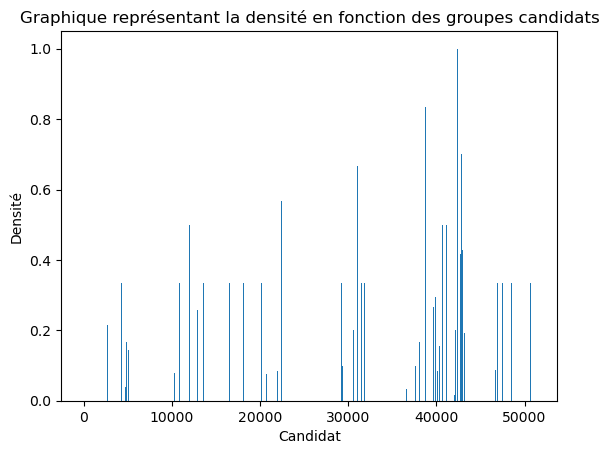

In [9]:
import matplotlib.pyplot as plt

# On va ici dessiner le graphique représentant la densité en fonction des groupes candidats
##############################################################################################################

# Extraire les clés et les valeurs du dictionnaire
cles = list(density_relevant.keys())
valeurs = list(density_relevant.values())

# Créer un graphique à barres
plt.bar(cles, valeurs)

# Ajouter des étiquettes
plt.xlabel('Candidat')
plt.ylabel('Densité')
plt.title('Graphique représentant la densité en fonction des groupes candidats')

# Afficher le graphique
plt.show()


In [24]:
# On souhaite conserver seulement les groupes dans le top 50% en terme de valeur de densité
# Pour cela, on se sert de la valeur de la médiane calculé ci-dessus

groupe_pertinents = relevant_groups(normal_density, median)
groupe_pertinents_densite = select_rg_density(normal_density, groupe_pertinents)
print(groupe_pertinents_densite)

Nombre total de communautés pertinentes :  1972
{6: 1.0, 30: 0.4666666666666667, 50: 0.5, 60: 0.4166666666666667, 71: 0.4166666666666667, 156: 1.0, 167: 0.35, 232: 0.6666666666666667, 284: 0.6666666666666667, 319: 0.5, 352: 0.5, 443: 0.6666666666666667, 499: 0.6666666666666667, 637: 0.6666666666666667, 651: 0.9166666666666666, 676: 0.5833333333333333, 840: 0.5833333333333333, 889: 0.5, 1065: 0.4166666666666667, 1225: 0.6666666666666667, 1330: 0.6666666666666667, 1349: 0.34920634920634924, 1441: 0.6, 1503: 0.5, 1534: 0.4166666666666667, 1632: 0.4666666666666667, 1794: 0.6666666666666667, 1802: 1.0, 1944: 0.5833333333333333, 1959: 0.38333333333333336, 2043: 0.5833333333333333, 2221: 0.6666666666666667, 2227: 0.5, 2432: 0.6666666666666667, 2462: 0.5, 2566: 0.34444444444444444, 2567: 0.8571428571428571, 2585: 0.5, 2605: 0.6666666666666667, 2609: 0.9166666666666666, 2624: 0.6666666666666667, 2631: 1.0, 2632: 0.6666666666666667, 2635: 0.7460317460317459, 2636: 0.6666666666666667, 2650: 0.866

In [26]:
# Boucle qui permet d'afficher le nombre de noeuds pour chaque candidat pertinent.
# Ceci peut nous permettre de réaliser un autre "filtrage" des groupes les plus pertinents

maxilen = 0
gp_maxilen = 0
for gp, gp_v in groupe_pertinents_densite.items():
    if maxilen < len(group_links[gp]):
        maxilen = len(group_links[gp])
        gp_maxilen = gp
    print("ID Candidat : ", gp, "--- Nbr noeuds : ", len(group_links[gp]))

ID Candidat :  6 --- Nbr noeuds :  5
ID Candidat :  30 --- Nbr noeuds :  6
ID Candidat :  50 --- Nbr noeuds :  4
ID Candidat :  60 --- Nbr noeuds :  4
ID Candidat :  71 --- Nbr noeuds :  4
ID Candidat :  156 --- Nbr noeuds :  4
ID Candidat :  167 --- Nbr noeuds :  5
ID Candidat :  232 --- Nbr noeuds :  3
ID Candidat :  284 --- Nbr noeuds :  3
ID Candidat :  319 --- Nbr noeuds :  4
ID Candidat :  352 --- Nbr noeuds :  4
ID Candidat :  443 --- Nbr noeuds :  3
ID Candidat :  499 --- Nbr noeuds :  3
ID Candidat :  637 --- Nbr noeuds :  3
ID Candidat :  651 --- Nbr noeuds :  4
ID Candidat :  676 --- Nbr noeuds :  4
ID Candidat :  840 --- Nbr noeuds :  4
ID Candidat :  889 --- Nbr noeuds :  6
ID Candidat :  1065 --- Nbr noeuds :  4
ID Candidat :  1225 --- Nbr noeuds :  3
ID Candidat :  1330 --- Nbr noeuds :  3
ID Candidat :  1349 --- Nbr noeuds :  7
ID Candidat :  1441 --- Nbr noeuds :  5
ID Candidat :  1503 --- Nbr noeuds :  4
ID Candidat :  1534 --- Nbr noeuds :  4
ID Candidat :  1632 --- 

In [36]:
# Fonction qui compte le nombre de liens dans chaque groupe pertinent pour affiner encore la selection des meilleurs candidats

def count_links(graph, nodes):
    link_counts = {}
    for grp in nodes:
        link_count = 0
        
        sous_graphe_nodes = group_links[grp]
        # Création du sous-graphe
        sous_graphe = G.subgraph(sous_graphe_nodes)
        link_count = sous_graphe.number_of_edges()                           
        link_counts[grp] = link_count

    return link_counts
    

graph = G 
nodes = groupe_pertinents
nbr_liens_grp = count_links(graph, nodes)

print (nbr_liens_grp)

{6: 8, 30: 7, 50: 5, 60: 5, 71: 5, 156: 5, 167: 8, 232: 3, 284: 3, 319: 5, 352: 5, 443: 3, 499: 3, 637: 3, 651: 5, 676: 5, 840: 5, 889: 12, 1065: 5, 1225: 3, 1330: 3, 1349: 13, 1441: 8, 1503: 5, 1534: 5, 1632: 7, 1794: 3, 1802: 3, 1944: 5, 1959: 8, 2043: 5, 2221: 3, 2227: 5, 2432: 3, 2462: 5, 2566: 9, 2567: 14, 2585: 5, 2605: 3, 2609: 5, 2624: 3, 2631: 3, 2632: 3, 2635: 11, 2636: 4, 2650: 8, 2681: 4, 2682: 5, 2717: 9, 2756: 3, 2800: 3, 2818: 5, 2855: 5, 2969: 10, 2988: 12, 3022: 3, 3056: 3, 3095: 3, 3194: 3, 3332: 5, 3345: 12, 3363: 3, 3388: 3, 3403: 5, 3417: 4, 3452: 3, 3488: 3, 3615: 5, 3638: 5, 3660: 3, 3753: 11, 3804: 3, 3982: 8, 4000: 5, 4016: 3, 4062: 3, 4067: 8, 4088: 5, 4100: 18, 4103: 3, 4118: 5, 4168: 4, 4189: 8, 4260: 7, 4264: 13, 4290: 3, 4307: 3, 4310: 8, 4312: 6, 4318: 3, 4442: 4, 4469: 13, 4480: 10, 4513: 3, 4517: 14, 4583: 12, 4590: 3, 4628: 4, 4633: 11, 4643: 5, 4673: 5, 4674: 3, 4713: 15, 4736: 4, 4743: 11, 4802: 3, 4835: 4, 4978: 5, 4982: 8, 5000: 3, 5025: 4, 5056: 3

In [37]:
# On affiche le candidat qui a le plus de noeud dans le graphe pour l'analyser ensuite

print("Groupe avec le plus de noeuds : ", gp_maxilen, " --- ", " Nbr de noeuds : ", maxilen, " --- ", "Nbr de liens : ", nbr_liens_grp[gp_maxilen])

Groupe avec le plus de noeuds :  11713  ---   Nbr de noeuds :  11  ---  Nbr de liens :  18


In [38]:
import datetime
import pytz

# Fonction qui affiche l'heure de début et de fin de chaque contact enregistré pour la communauté choisie

def affichageHeure(unix_timestamp):
    dt = datetime.datetime.fromtimestamp(unix_timestamp, pytz.UTC)
    local_tz = pytz.timezone('Europe/Paris')
    dt = dt.astimezone(local_tz)
    formatted_datetime = dt.strftime("%H:%M:%S")
    
    return formatted_datetime

for i in range(maxilen):
    print("Contact n°", i, " Heure de début : ", affichageHeure(group_links[gp_maxilen][i][0])," Heure de fin : ",affichageHeure(dictionnaire_temps_max[group_links[gp_maxilen][i]]))
    

Contact n° 0  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 1  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 2  Heure de début :  13:21:20  Heure de fin :  13:21:20
Contact n° 3  Heure de début :  13:21:20  Heure de fin :  13:21:20
Contact n° 4  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 5  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 6  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 7  Heure de début :  13:21:20  Heure de fin :  13:21:20
Contact n° 8  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 9  Heure de début :  13:21:20  Heure de fin :  13:21:40
Contact n° 10  Heure de début :  13:21:20  Heure de fin :  13:21:40


In [39]:
# Affichage plus précis de chaque contact de la communauté (pour rappel --> format : (t_début, i, j) : t_fin)

for i in range(maxilen):
    print(group_links[gp_maxilen][i], " : ", dictionnaire_temps_max[group_links[gp_maxilen][i]])
    

(44480, 1625, 1851)  :  44500
(44480, 1625, 1861)  :  44500
(44480, 1625, 1911)  :  44480
(44480, 1648, 1761)  :  44480
(44480, 1648, 1861)  :  44500
(44480, 1696, 1911)  :  44500
(44480, 1720, 1761)  :  44500
(44480, 1720, 1889)  :  44480
(44480, 1761, 1851)  :  44500
(44480, 1851, 1911)  :  44500
(44480, 1861, 1889)  :  44500


In [40]:
# La même chose mais on affiche les classes de chaque indivudus plutôt que leurs IDs 
for i in range(maxilen):
    individuX = group_links[gp_maxilen][i]
    liste_maj = list(individuX)
    liste_maj[1] = df.loc[df['i'] == liste_maj[1], "Ci"].values[0]
    liste_maj[2] = df.loc[df['j'] == liste_maj[2], "Cj"].values[0]
    print(liste_maj, " : ", dictionnaire_temps_max[group_links[gp_maxilen][i]])
    

[44480, '2A', '2B']  :  44500
[44480, '2A', '2B']  :  44500
[44480, '2A', '2A']  :  44480
[44480, '2A', '1A']  :  44480
[44480, '2A', '2B']  :  44500
[44480, '1B', '2A']  :  44500
[44480, '3A', '1A']  :  44500
[44480, '3A', '2B']  :  44480
[44480, '1A', '2B']  :  44500
[44480, '2B', '2A']  :  44500
[44480, '2B', '2B']  :  44500


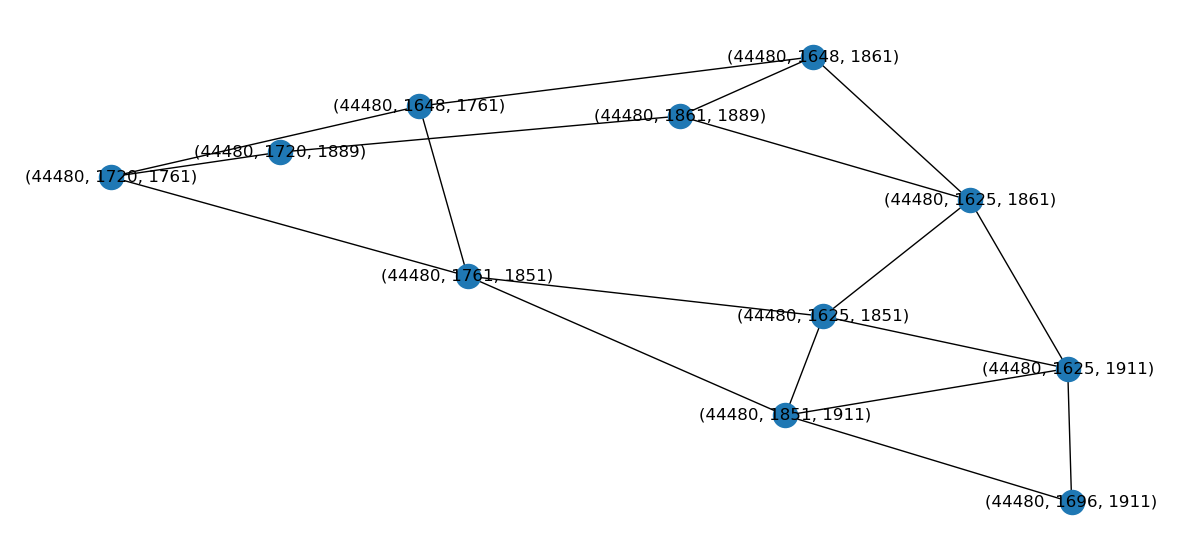

In [41]:
# On affiche une communauté, celui qui as le plus de noeud "gp_maxilen"

sous_graphe_nodes = group_links[gp_maxilen]

# Création du sous-graphe
sous_graphe = G.subgraph(sous_graphe_nodes)

fig, ax = plt.subplots(figsize=(15, 7))
# Affichage du sous-graphe avec Matplotlib
nx.draw(sous_graphe, with_labels=True, arrows=False, ax=ax)
plt.show()